# Recreating the `demo_derangments_basic` model from the [work](https://qtechtheory.org/derangement_circuits/) of Balint Koczor
---

In [1]:
from asset_func import *
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (NoiseModel, depolarizing_error)

## The circuit
---

### The observable:

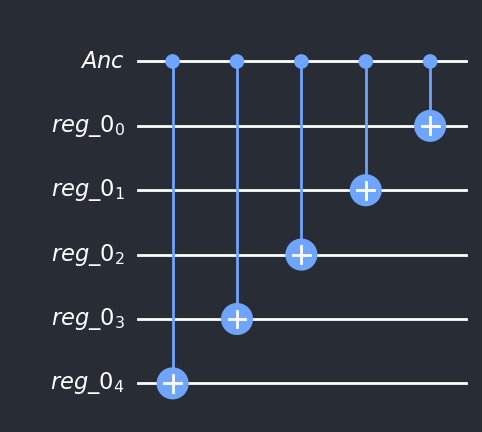

In [2]:
obs = iniQC(1,5,1)
cnots(obs,[0])
obs.draw()

### The full circuit:

/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/noszi/Developer/python_env/env_Quantum/lib/python3.11/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


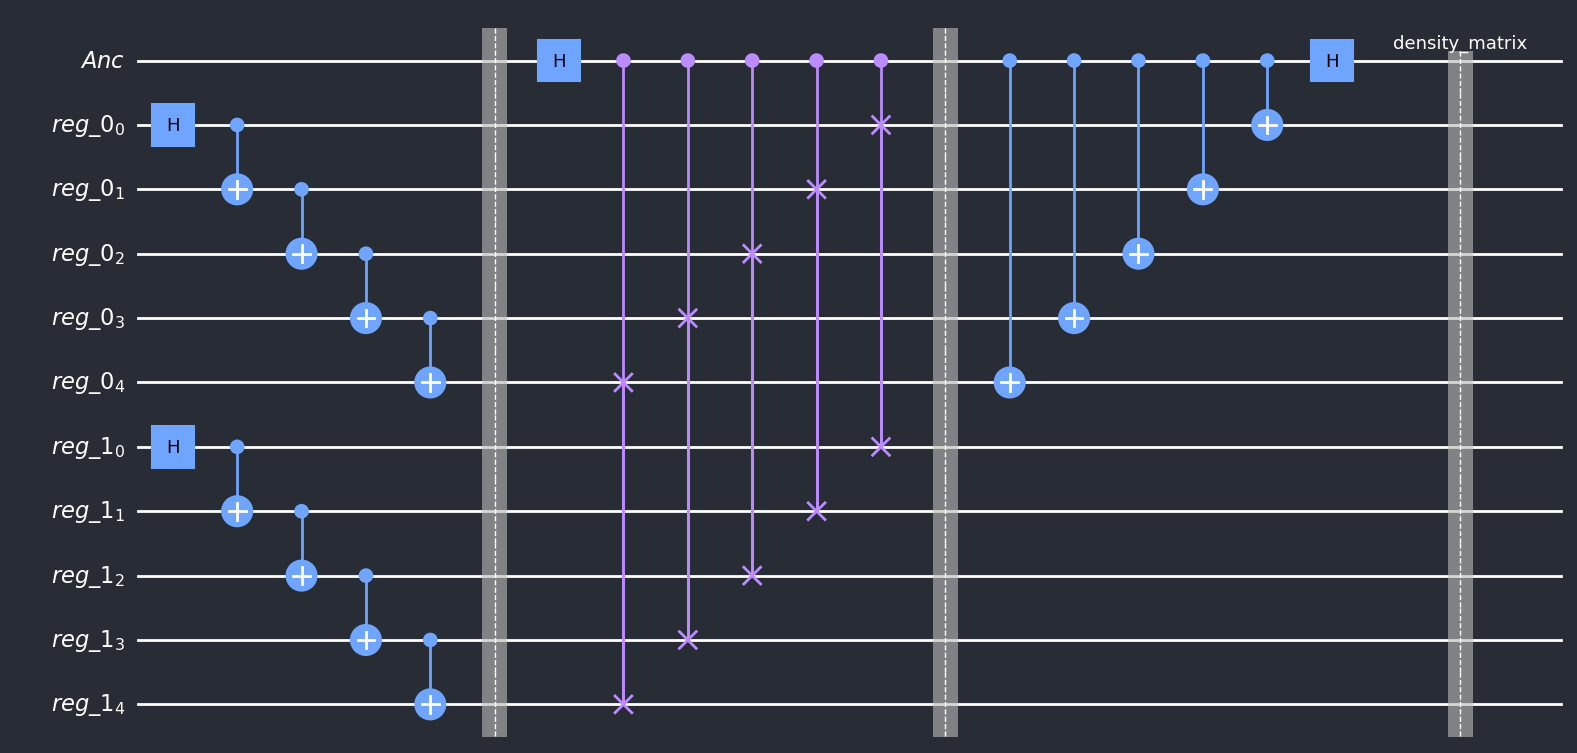

In [3]:
full_qc = circ_assembler(numReg = 2, numQ = 5, numAnc = 1, sigma = obs, 
                         basis_gates = ['cx'], nb_shots = 0, der_op = True)

full_qc.draw()

## Expectation value
---

### Exact expectation value:
The known expectation value of the circuit is $1$. We can also check this using the `circ_tester()` function which returns the expectation value both for the mitigated and unmitigated (circuit without the derangement operator) circuits. 

In [4]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['cx'] # we are not decomposing the observable
nb_shots = 0 # we are interested in the exact (algeabraic) expectation value hence no shots
sim = AerSimulator(method = 'density_matrix') # we calcualte the expectation value from the density matrix

mit, unmit = circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, sim = sim)

print('The mitigated expectation value is: {} and the unmitigated is: {}.'.format(mit, unmit))


The mitigated expectation value is: (1.0000000000000004-0j) and the unmitigated is: (1.0000000000000004-0j).


### Estimated expectation value, with the noise model from the demo:

In the mathematica demo, a depolarizing error with probability $p = 0.2$ is added to after each $CX$ gate of the $\text{GHZ}$ state. Here we reproduce the same noise model and obtain the expectation value first by performing the exact calculation second by estimating it using $10000$ shots.

In order to only apply the depolarizing error to the $CX$ gates for the $\text{GHZ}$ state and not for the observable, we redifine the observable by decomposing it into costum $CX$ gates:

In [5]:
qc = QuantumCircuit(2, name = 'costum_cx')
qc.cx(0,1)
costum_cx = qc.to_gate()

redifining the `cnots` function to use our costum gates:

In [6]:
def cnots(qc, regs):

    """ Applies a cx gate between the Ancilla qubit and each qubit of the selected quantum registers. 
    
    
    Parameters
    ----------
    qc : qiskit quantum circuit
        The circuit to which the cx gates are applied
    regs : int
        The register to which the cx gates are applied to. 
    Returns
    -------
    A qiskit quantum circuit.

    """

    ancilla_qubit = qc.ancillas[0]
    registers = qc.qregs[1:]
    numQubits = registers[0].size

    for reg in regs:
        for qubit in reversed(range(numQubits)):
            qc.append(costum_cx,(ancilla_qubit, registers[reg][qubit])) # <-- redifning here

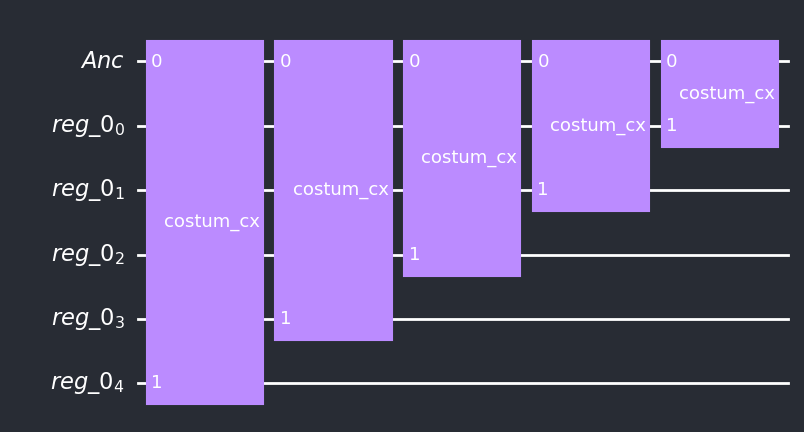

In [7]:
obs = iniQC(1,5,1)
cnots(obs,[0])
obs.draw() # uncomment to show redifined observable

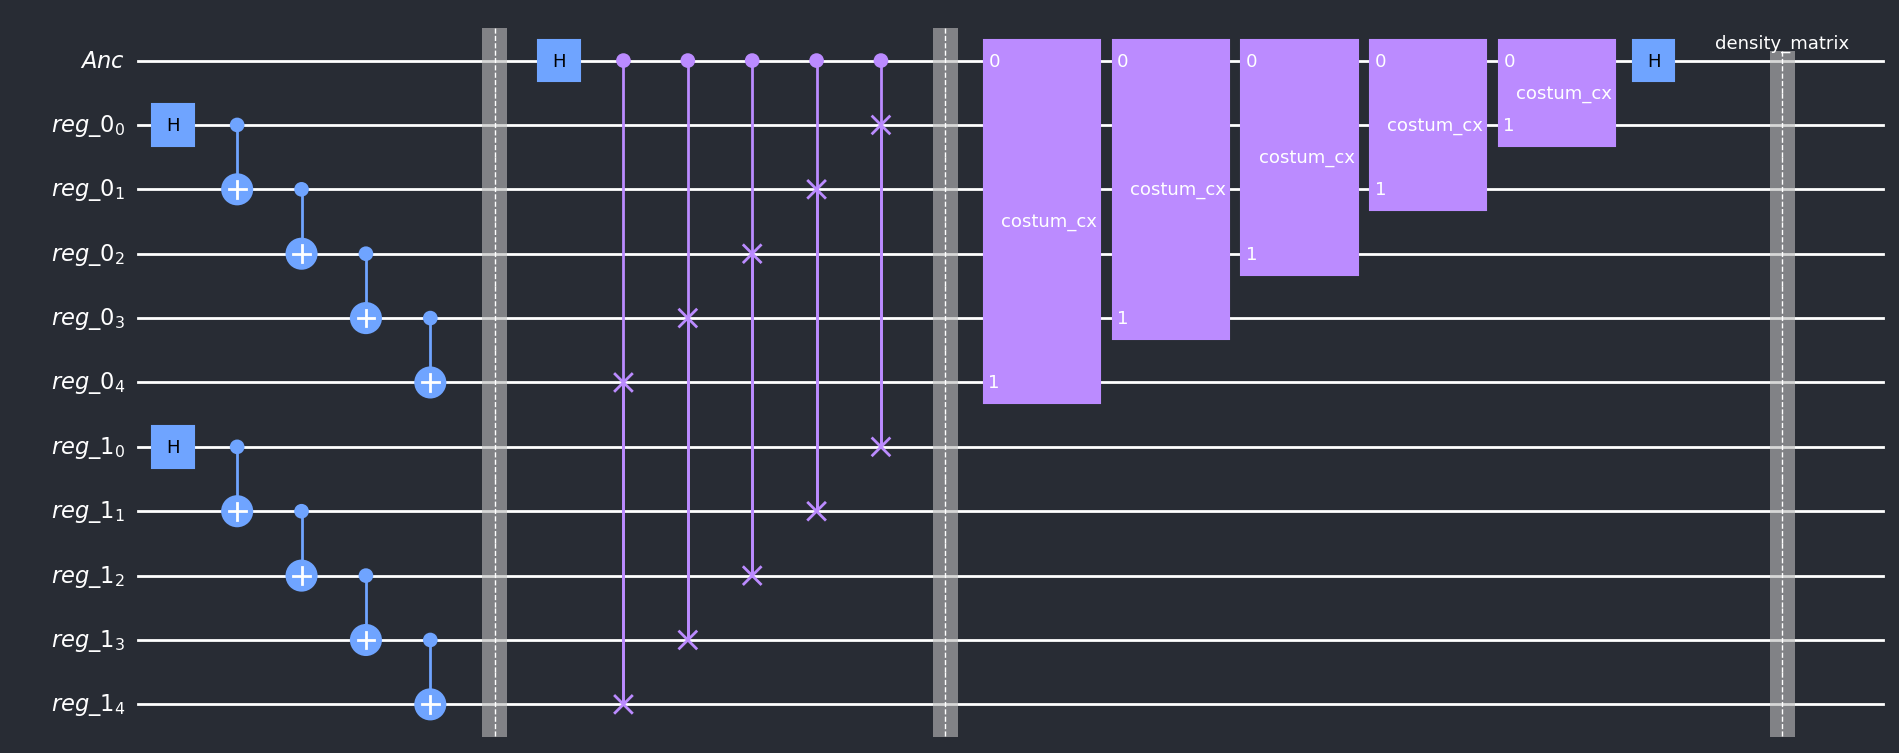

In [8]:
full_qc = circ_assembler(numReg = 2, numQ = 5, numAnc = 1, sigma = obs, 
                         basis_gates = ['costum_cx'], nb_shots = 0, der_op = True)

full_qc.draw(fold = -1) # uncomment to show circuit with costum cx gates

#### Creating the noise model:

In [9]:
error = 0.02 # defining error probability

err_2q = depolarizing_error(error, 2) # 2 qubit error for cx gates in the GHZ state

noise_simple = NoiseModel() # create noise model
noise_simple.add_all_qubit_quantum_error(err_2q, ['cx'])

noise_simple.add_basis_gates(['h', 'cx', 'cswap', 'costum_cx'])

Assigning the noise model to the simulator (one for exact calculation, one for estimation using $10000$ shots):

In [10]:
sim_exact = AerSimulator(noise_model = noise_simple, method = 'density_matrix')
sim_estimate = AerSimulator(noise_model = noise_simple)

Finally evaulting the circuit:

In [11]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['costum_cx'] # we are not decomposing the observable
nb_shots = 0 # we are interested in the exact (algeabraic) expectation value hence no shots
sim = sim_exact # we calcualte the expectation value from the density matrix
mit, unmit = circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, sim = sim)

print('The mitigated exact expectation value is: {} and the unmitigated is: {}.'.format(mit, unmit))

The mitigated exact expectation value is: (1.0000000000000004-0j) and the unmitigated is: (1.0000000000000002-0j).


In [12]:
copies = 2 # we create two copies 
qubits = 5 # each copy consists of 5 qubits (and 1 ancilla qubit)
sigma = obs # we are using the 'cnots' observable
basis_gates = ['costum_cx'] # we are not decomposing the observable
nb_shots = 10000 # we are interested in the exact (algeabraic) expectation value hence no shots
sim = sim_estimate # we calcualte the expectation value from the density matrix

mit, unmit = circ_tester(numReg = copies, numQ = qubits, numAnc = 1, sigma = obs, 
                         basis_gates = basis_gates, nb_shots = nb_shots, sim = sim)

print('The mitigated expectation value is: {} and the unmitigated is: {}.'.format(mit, unmit))

{'1': 1095, '0': 8905} 10000
{'1': 639, '0': 9361} 10000
{'1': 826, '0': 9174} 10000
{'0': 10000} 10000
The mitigated expectation value is: 0.8954368264159595 and the unmitigated is: 0.8348.
